In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('.')

In [2]:
import numpy as np
import pandas as pd
import pyro
from pyro import distributions as dist
from sklearn import metrics as sk_mtr
import torch
from torch.distributions import constraints
from src import utils
from src.nb import dataset
from src.nb import utils

pyro.enable_validation(True)

NameError: name 'empty_totalcharges_to_zero' is not defined

## Load dataset (Iris)

In [3]:
iris_dataset = dataset.load_iris_dataset()

Full (150, 4) (150,)
Train (120, 4) (120,)
Test (30, 4) (30,)


## Naive Bayes

![](https://jcaip.github.io/images/medimg/nbayes.png)

$$\mathbb{P}(c_k | x_1, x_2, \ldots, x_n) \propto \mathbb{P}(c_k, x_1, x_2, \ldots, x_n) = \mathbb{P}(c_k) \prod_{i=1}^{n}\mathbb{P}(x_i | c_k)$$

$$\hat{y} = \operatorname*{argmax}_{k \in \{1, 2, \ldots, K\}} \mathbb{P}(c_k | x_1, x_2, \ldots, x_n)$$

In [4]:
class GaussianNBClassifier:
    def __init__(self, num_epochs=500, lr=1e-2, verbose=False):
        self._num_epochs = num_epochs #ilość przejść w trakcie treningu
        self._lr = lr                 #learning rate
        self._verbose = verbose       # ??
        
        self._num_cls = None          # Liczba klas.
        
        self._c_logits = None        # ??
        self._num_probs = None #     ??
        
    def fit(self, X, y):        
        history = utils.train_svi(
            model=self._model,
            guide=self._guide,
            X=X, 
            y=y,
            num_epochs=self._num_epochs,
            lr=self._lr,
        )
        if self._verbose:
            utils.visualize_nb_parameters(history)
        else:
            return history
    
    def predict(self, X):
        pred = pyro.infer.Predictive(
            model=self._model,
            guide=self._guide,
            num_samples=1,
            return_sites=('logP(c|x)',),
        )
        log_pcx = pred(X)['logP(c|x)'].detach().squeeze(0).squeeze(0)
        y_pred = torch.argmax(log_pcx, dim=-1)
        return y_pred
    
    def _model(self, X, y=None):    # X- dane (dataframe), y - wektor klas.
        if y is not None:  # training mode Gdy podamy wektor z klasami. 
            self._num_cls = max(y) + 1 # zakładamy że wszystkie klasy znajdą się w zbiorze treningowym.
                                       # W tej implementacji chyba zakładamy że klasy są zapisane od 0 do jakiegoś N dlatego N+1 to liczba klas.
            #print('class count',self._num_cls)
            numerical_cols = X.columns.values  #przypisanie zmiennych numerycznych 
            self._init_c_logits() #Inicjalizacja parametru - wektor prawdopodobieństw P(c_K)
            #print('logits',self._c_logits)
            self._init_num_params(X, numerical_cols)
            #print('num_params',self._num_probs)
            self._observe_numerical_features_given_classes(X, y)

        self._observe_classes(X, y)
        
    def _guide(self, X, y=None):
        pass
    
    def _init_c_logits(self): 
        self._c_logits = pyro.param(
            'c_logits',
            torch.ones(self._num_cls).div(self._num_cls),
            constraint=constraints.simplex,
        )
        
    def _init_num_params(self, X, numerical_cols):
        self._num_probs = { #tworzenie paramtrów odpowiedzialnych za rozkłady gaussianów dla każdej z K klas i N cech 
            col: {
                'mu': pyro.param(f'{col}_mu', torch.zeros(self._num_cls)), #num_cls to nasze K we wzorze.
                'sigma': pyro.param(f'{col}_sigma', torch.ones(self._num_cls)),
            }
            for col in numerical_cols# numberical_cols to nasze N we wzorze up.Czyli N cech numerycznych
        }
        
    def _observe_numerical_features_given_classes(self, X, y):
        for c in range(self._num_cls): 
            x_c = X[y==c]
            with pyro.plate(f'data-numerical-{c}', x_c.shape[0]):
                for nc, v in self._num_probs.items(): #nc-name_column, v-słownik z mu i sigma
                    pyro.sample(
                        f'P(x_{nc}|c={c})', 
                        dist.Normal(v['mu'][c], v['sigma'][c]),
                        obs=torch.tensor(x_c[nc].values),
                    )
                    
    def _get_log_likelihood(self, X):
        log_lk = [] #lista log_likelihoodów
        
        for c in range(self._num_cls): #dla każdej klasy
            lps = []
            
            lps.extend([
                dist.Normal(v['mu'][c], v['sigma'][c]).log_prob(torch.tensor(X[nc].values))
                for nc, v in self._num_probs.items() # dla każdej cechy numerycznej
            ])

            log_lk.append(torch.stack(lps).sum(dim=0))
            
        return torch.stack(log_lk).t()
    
    def _observe_classes(self, X, y):
        if y is not None:
            y = torch.tensor(y)
        
        log_lk = self._get_log_likelihood(X)
        #print('log_lk',log_lk)
    
        log_pcx = pyro.deterministic('logP(c|x)', self._c_logits.log() + log_lk) # prawdopodobieństo klasy od cechy
        
        with pyro.plate('data-pred', X.shape[0]):    
            pyro.sample(
                'c',
                dist.Categorical(logits=log_pcx),
                obs=y,
            )

Loss = 4398.438970578416
Loss = 2192.9435605780745
Loss = 1518.5291060198385
Loss = 1251.1077767644688
Loss = 1065.355055475961
Loss = 941.8256710911534
Loss = 838.9553693128262
Loss = 755.5121250341128
Loss = 683.9378756079906
Loss = 628.4483253577258



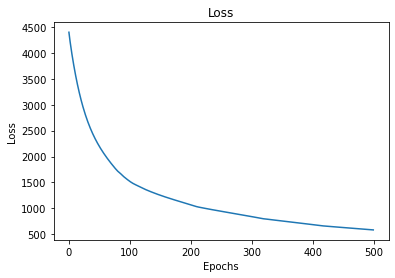

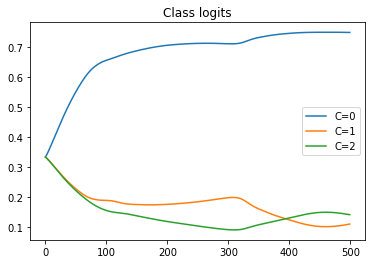

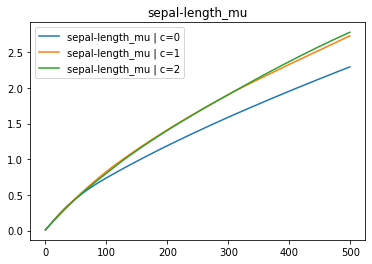

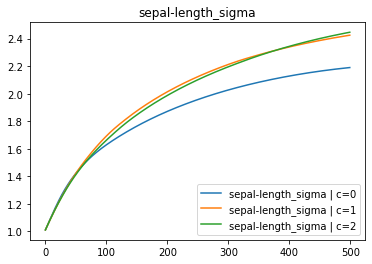

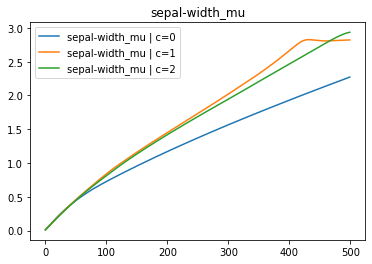

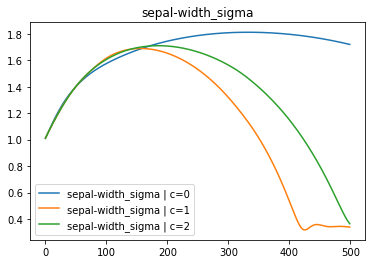

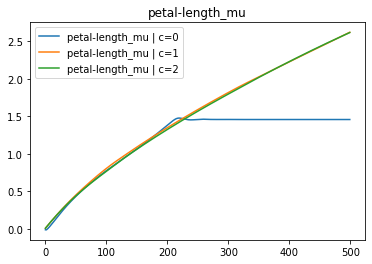

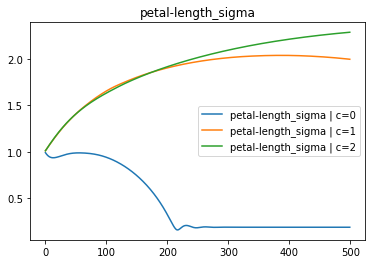

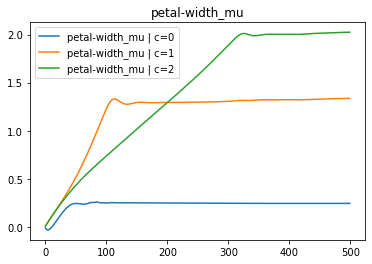

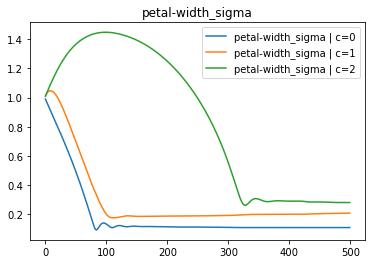

In [5]:
pyro.clear_param_store()
clf = GaussianNBClassifier(
    num_epochs=500,
    verbose=True,
)
clf.fit(X=iris_dataset['train']['X'], y=iris_dataset['train']['y'])

In [6]:
for tt in ('train', 'test'):
    print(tt)
    print(sk_mtr.classification_report(
        y_true=iris_dataset[tt]['y'],
        y_pred=clf.predict(X=iris_dataset[tt]['X']),
    ))

train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.90      0.90      0.90        40
           2       0.90      0.90      0.90        40

    accuracy                           0.93       120
   macro avg       0.93      0.93      0.93       120
weighted avg       0.93      0.93      0.93       120

test
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



## Homework (part 1)
Extend the `GaussianNBClassifier` class so it can handle categorical features. Re-use as much code as possible.
Automatically identify categorical columns from dataset.

### Load dataset (CMC)

In [7]:
cmc_dataset = dataset.load_cmc(N=200)

Full (200, 9) (200,)
Train (160, 9) (160,)
Test (40, 9) (40,)


In [8]:
cmc_dataset['train']['X'].head()

,age,w-education,h-education,num-children,w-religion,w-working,h-occupation,sol-index,media-exposure
0,34,1,1,4,0,1,2,1,0
1,46,1,2,6,0,0,2,3,0
2,23,3,2,3,1,1,2,2,0
3,36,0,1,4,1,1,2,0,1
4,32,3,3,3,1,1,0,3,0


In [9]:
cmc_dataset['train']['y']

array([2, 2, 1, 2, 0, 0, 2, 2, 0, 2, 0, 1, 1, 0, 2, 0, 0, 1, 2, 2, 0, 1,
       2, 2, 0, 1, 0, 0, 2, 1, 2, 1, 1, 0, 1, 2, 2, 2, 2, 2, 0, 1, 2, 2,
       1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 0, 0, 0, 2, 0, 1, 1, 2, 2, 1,
       0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 2, 2, 2, 0, 2, 2,
       2, 0, 0, 0, 0, 2, 1, 0, 2, 1, 1, 2, 0, 1, 2, 2, 2, 0, 2, 2, 1, 2,
       1, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 1, 0, 2, 0, 1, 0, 1, 2,
       0, 0, 2, 1, 0, 1], dtype=int64)

Loss = 91054.74835014343
Loss = 44324.52847576141
Loss = 30968.355555057526
Loss = 24464.666637420654
Loss = 20479.868163228035
Loss = 17748.114205241203
Loss = 15742.099558770657
Loss = 14198.15438079834
Loss = 12968.398709923029
Loss = 11962.907512545586
Loss = 11123.606550127268
Loss = 10411.169943034649
Loss = 9797.932294860482
Loss = 9263.843256756663
Loss = 8793.967643260956
Loss = 8376.964037790895
Loss = 8004.057880625129
Loss = 7668.343870319426
Loss = 7364.3187482059
Loss = 7087.530200891197
Loss = 6834.345123402774
Loss = 6601.7568060308695
Loss = 6387.253826469183
Loss = 6188.731701463461
Loss = 6004.4029145389795
Loss = 5832.742579169571
Loss = 5672.439724311233
Loss = 5522.359205406159
Loss = 5381.524350542575
Loss = 5249.072255279869
Loss = 5124.250451978296
Loss = 5006.395757354796
Loss = 4894.921685110778
Loss = 4789.306701328605
Loss = 4689.090041093528
Loss = 4593.8557918556035
Loss = 4503.231687638909
Loss = 4416.882731722668
Loss = 4334.508592266589
Loss = 4255.835

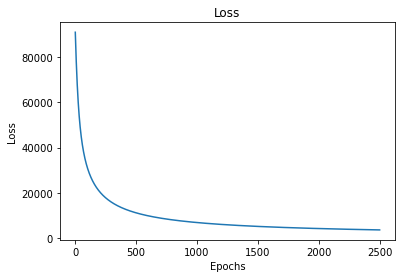

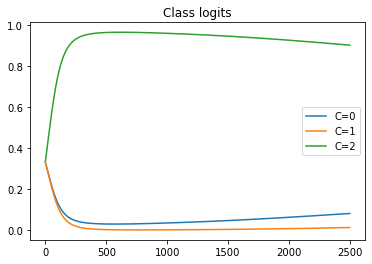

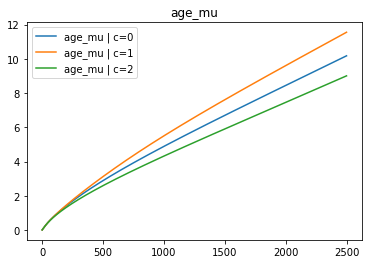

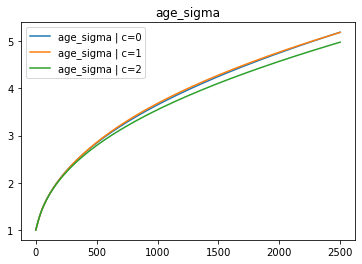

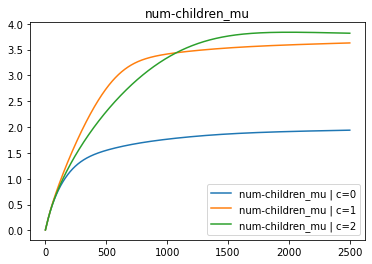

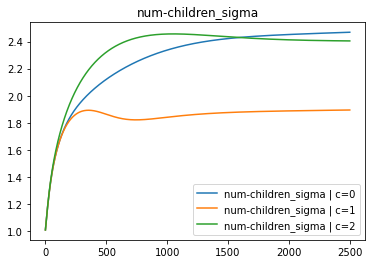

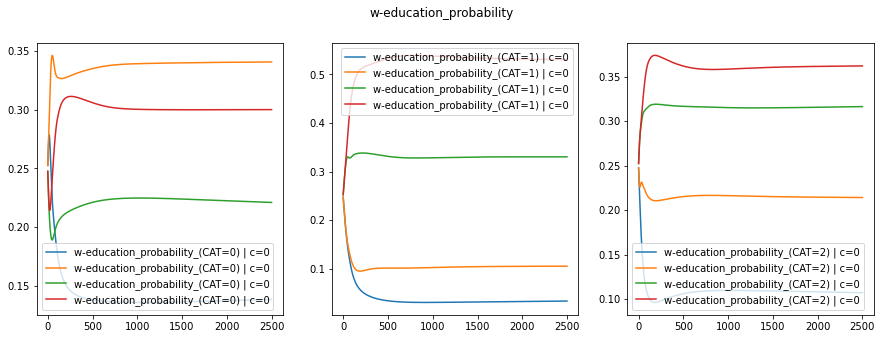

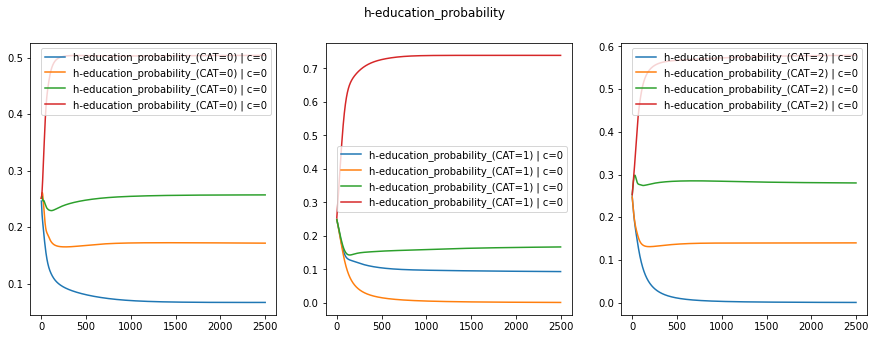

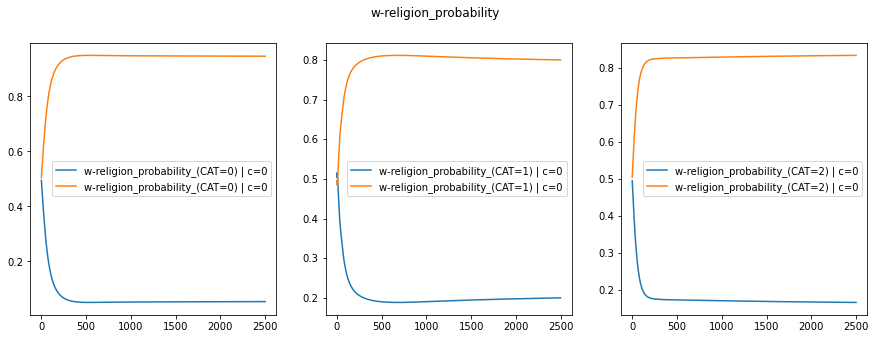

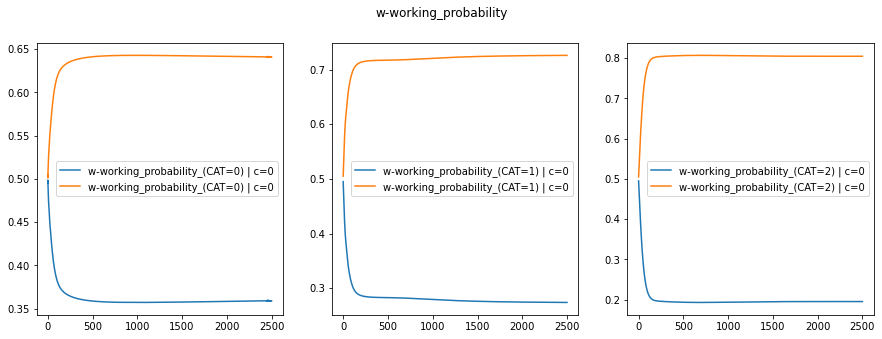

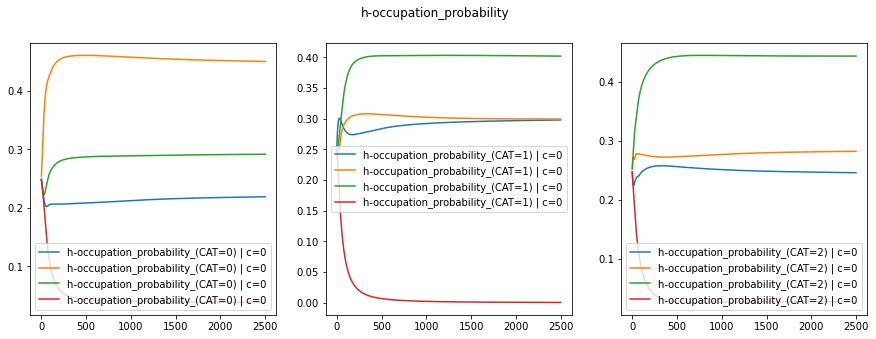

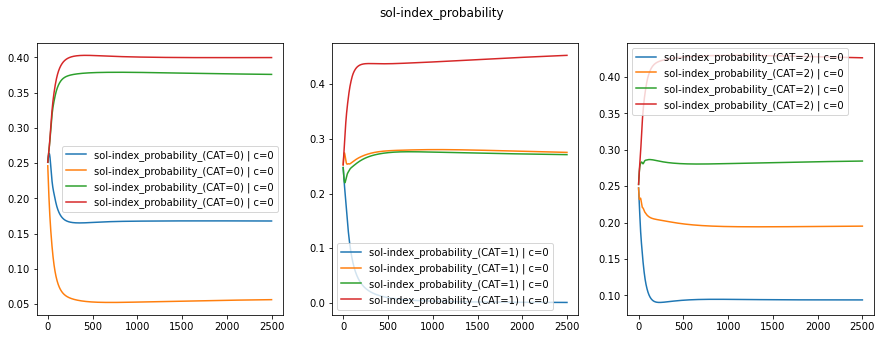

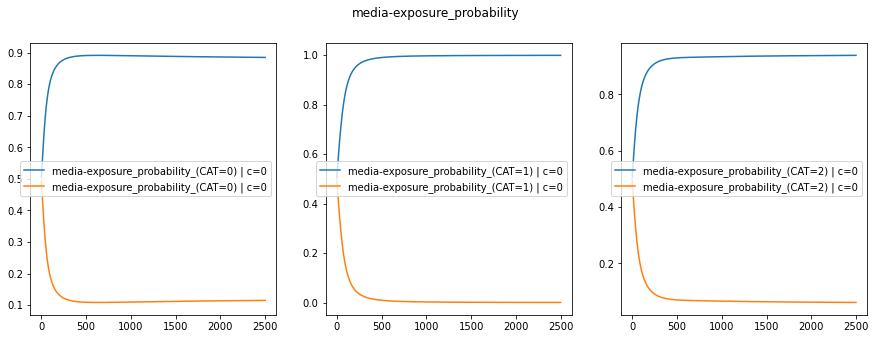

In [10]:
class FullNBClassifier(GaussianNBClassifier):
    def __init__(self, num_epochs=500, lr=1e-2, verbose=False):
        super().__init__(num_epochs,lr,verbose)
        self._cat_probs = None #placeholder dla parametrów rozkładu categorycznego od cechy
        pass
    
    def _init_cat_params(self, X, categorical_cols): #torch.ones(classes,feature)/feature
        self._cat_probs = { #tworzenie paramtrów odpowiedzialnych za rozkłady gaussianów dla każdej z K klas i N cech 
            col: { #col - column name
                'probability': pyro.param(f'{col}_probability', torch.ones(self._num_cls,X[col].nunique()),constraint=constraints.simplex), #num_cls to nasze K we wzorze. 
            } # tensor ten wygląda np tak dla 3 klas : [0,0,0] na start. czyli prawodopodobieństwo bycia w danej klasie z rozkładu cat
            for col in categorical_cols# numberical_cols to nasze N we wzorze up.Czyli N cech numerycznych
        }
        
    def _model(self, X, y=None):    # X- dane (dataframe), y - wektor klas.
        if y is not None:  # training mode Gdy podamy wektor z klasami. 
            self._num_cls = max(y) + 1 # zakładamy że wszystkie klasy znajdą się w zbiorze treningowym.
                                       # W tej implementacji chyba zakładamy że klasy są zapisane od 0 do jakiegoś N dlatego N+1 to liczba klas.
            categorical_cols = X.select_dtypes(include=['category'])
            numerical_cols = X.select_dtypes(exclude=['category'])  #przypisanie zmiennych numerycznych 
            self._init_c_logits() #Inicjalizacja parametru - wektor prawdopodobieństw P(c_K)
            self._init_num_params(X, numerical_cols)
            self._init_cat_params(X, categorical_cols)
            #print(self._cat_probs)
            self._observe_numerical_features_given_classes(X, y)
            self._observe_categorical_features_given_classes(X,y)
        self._observe_classes(X, y)
        
    def _observe_categorical_features_given_classes(self, X, y):
        for c in range(self._num_cls):  # dla każdej klasy
            x_c = X[y==c] # weź dane których klasa odpowiada iteratowi z powyżej
            with pyro.plate(f'data-categorical-{c}', x_c.shape[0]):  #c - labelka klasy
                for nc, v in self._cat_probs.items(): #nc - name column v parametr dla rozkładu categorycznego
                    pyro.sample(
                        f'P(x_{nc}|c={c})',
                        dist.Categorical(v['probability'][c]),
                        obs=torch.tensor(x_c[nc].values)
                    )
    def _get_log_likelihood(self, X):
        log_lk = [] #lista log_likelihoodów
        
        for c in range(self._num_cls): #dla każdej klasy
            #dla numerycznych
            lps = []
            lps.extend([
                dist.Normal(v['mu'][c], v['sigma'][c]).log_prob(torch.tensor(X[nc].values))
                for nc, v in self._num_probs.items() # dla każdej cechy numerycznej
            ])
            #dla categorycznych
           # print(self._cat_probs.items())
            lps.extend([
                dist.Categorical(v['probability'][c]).log_prob(torch.tensor(X[nc].values))
                for nc, v in self._cat_probs.items() # nc - name_column v-słownik z parametrami
            ])
            
            
            log_lk.append(torch.stack(lps).sum(dim=0))
           
        return torch.stack(log_lk).t()
                    
pyro.clear_param_store()          
clf = FullNBClassifier(
    num_epochs=2500,
    verbose=True,
)
clf.fit(X=cmc_dataset['train']['X'], y=cmc_dataset['train']['y'])

In [11]:
for tt in ('train', 'test'):
    print(tt)
    print(sk_mtr.classification_report(
        y_true=cmc_dataset[tt]['y'],
        y_pred=clf.predict(X=cmc_dataset[tt]['X']),
    ))

train
              precision    recall  f1-score   support

           0       0.78      0.49      0.60        43
           1       0.42      0.41      0.42        34
           2       0.65      0.78      0.71        83

    accuracy                           0.62       160
   macro avg       0.62      0.56      0.58       160
weighted avg       0.64      0.62      0.62       160

test
              precision    recall  f1-score   support

           0       0.50      0.20      0.29        10
           1       0.45      0.56      0.50         9
           2       0.56      0.67      0.61        21

    accuracy                           0.53        40
   macro avg       0.50      0.47      0.46        40
weighted avg       0.52      0.53      0.50        40



In [12]:
torch.ones(1,3)

tensor([[1., 1., 1.]])